In [1]:
from derivatives import (
    first_derivative,
    second_derivative,
    )
from scipy.integrate import solve_ivp
from scipy.linalg import solve
from sklearn.gaussian_process import kernels
import matplotlib.pyplot as plt 
import numpy as np
import sklearn

In [2]:
# %% PDE Heat Diffusion Equation
a = 0.01
l = 0.1
L = 1
Nx = 200
dx = L / (Nx - 1)
x = np.linspace(0, L, Nx)
u0 = np.exp((-np.sin(np.pi * x)**2)/2)
t_span = (0, 10)
t_eval = np.linspace(0, 10, 200)

def diffusion(t, u, a, dx):
    u[0] = 0
    u[-1] = 0
    uxx = second_derivative(u, dx)
    ut = a * uxx
    return np.array(ut)

u_diff = []
u_diff.append(solve_ivp(diffusion, t_span=t_span, y0 = u0, args=(a, dx), t_eval=t_eval).y.T)
u_diff = np.squeeze(u_diff)

m, n = u_diff.shape

In [3]:
## Noises
u_diff_noisy_normal = u_diff + np.random.normal(scale=0.1, size=(m, n))
u_diff_noisy_uniform = u_diff + np.random.uniform(size=(m, n))
u_diff_noisy_poisson = u_diff + np.random.poisson(lam=0.01, size=(m, n))
u_diff_noisy_laplace = u_diff + np.random.laplace(scale=1, size=(m, n))
u_diff_noisy_exponential = u_diff + np.random.exponential(scale=0.1, size=(m, n))

<Figure size 640x480 with 0 Axes>

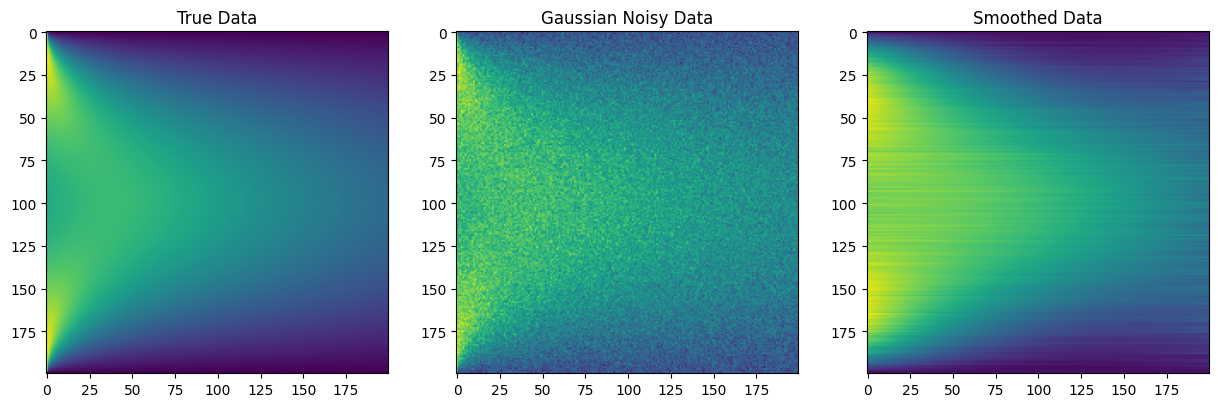

<Figure size 640x480 with 0 Axes>

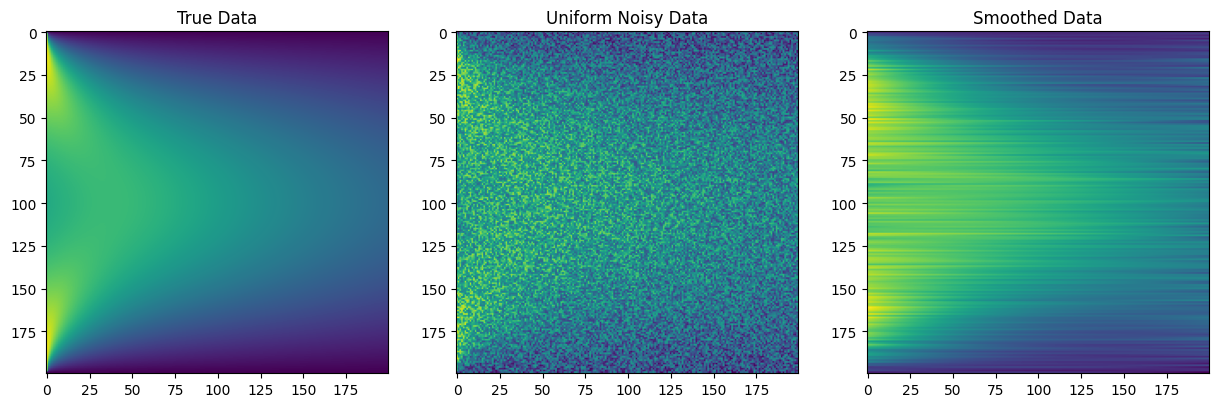

<Figure size 640x480 with 0 Axes>

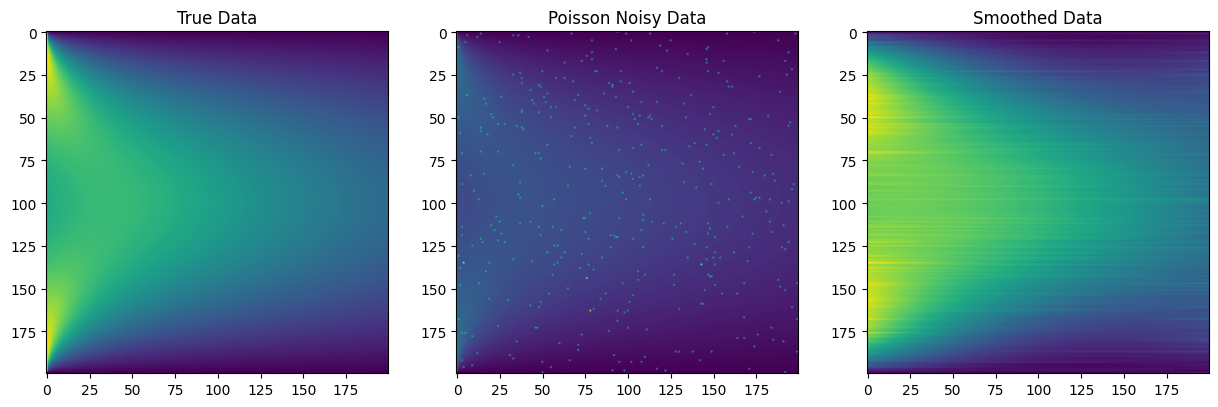

<Figure size 640x480 with 0 Axes>

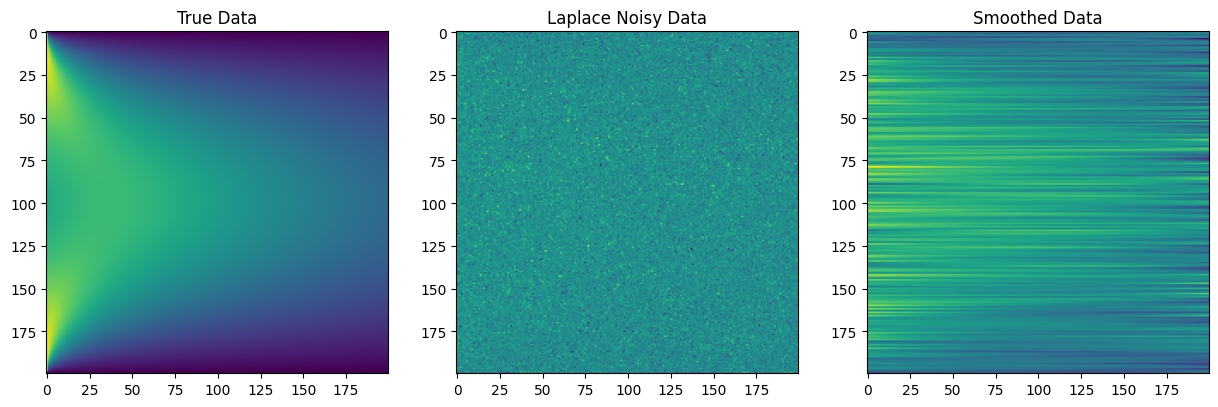

<Figure size 640x480 with 0 Axes>

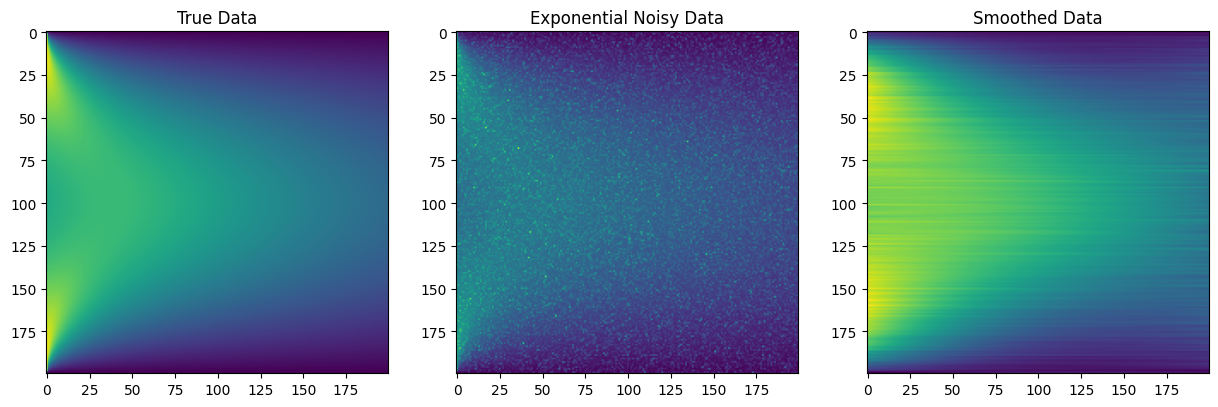

In [4]:
# %% Smoothing
## Kernels
rbf = kernels.RBF(length_scale=l)
x = x[:, None]
u_rbf = sklearn.metrics.pairwise.polynomial_kernel(x)
# u_rbf = rbf(x, x)
u_diff_smooth_normal = u_rbf @ solve((u_rbf + 0.1*np.eye(Nx)), u_diff_noisy_normal)
plt.figure()
fig, axis = plt.subplots(1, 3, figsize=(15, 5))
axis[0].imshow(u_diff.T)
axis[0].set_title('True Data')
axis[1].imshow(u_diff_noisy_normal.T)
axis[1].set_title('Gaussian Noisy Data')
axis[2].imshow(u_diff_smooth_normal.T)
axis[2].set_title('Smoothed Data')
plt.show()

u_diff_smooth_uniform = u_rbf @ solve((u_rbf + 0.1*np.eye(Nx)), u_diff_noisy_uniform)
plt.figure()
fig, axis = plt.subplots(1, 3, figsize=(15, 5))
axis[0].imshow(u_diff.T)
axis[0].set_title('True Data')
axis[1].imshow(u_diff_noisy_uniform.T)
axis[1].set_title('Uniform Noisy Data')
axis[2].imshow(u_diff_smooth_uniform.T)
axis[2].set_title('Smoothed Data')
plt.show()

u_diff_smooth_poisson = u_rbf @ solve((u_rbf + 0.1*np.eye(Nx)), u_diff_noisy_poisson)
plt.figure()
fig, axis = plt.subplots(1, 3, figsize=(15, 5))
axis[0].imshow(u_diff.T)
axis[0].set_title('True Data')
axis[1].imshow(u_diff_noisy_poisson.T)
axis[1].set_title('Poisson Noisy Data')
axis[2].imshow(u_diff_smooth_poisson.T)
axis[2].set_title('Smoothed Data')
plt.show()

u_diff_smooth_laplace = u_rbf @ solve((u_rbf + 0.1*np.eye(Nx)), u_diff_noisy_laplace)
plt.figure()
fig, axis = plt.subplots(1, 3, figsize=(15, 5))
axis[0].imshow(u_diff.T)
axis[0].set_title('True Data')
axis[1].imshow(u_diff_noisy_laplace.T)
axis[1].set_title('Laplace Noisy Data')
axis[2].imshow(u_diff_smooth_laplace.T)
axis[2].set_title('Smoothed Data')
plt.show()

u_diff_smooth_exponential = u_rbf @ solve((u_rbf + 0.1*np.eye(Nx)), u_diff_noisy_exponential)
plt.figure()
fig, axis = plt.subplots(1, 3, figsize=(15, 5))
axis[0].imshow(u_diff.T)
axis[0].set_title('True Data')
axis[1].imshow(u_diff_noisy_exponential.T)
axis[1].set_title('Exponential Noisy Data')
axis[2].imshow(u_diff_smooth_exponential.T)
axis[2].set_title('Smoothed Data')
plt.show()

In [6]:
def rbf_kernel_derivative(x1, x2, length_scale=l, order=1):
    K = rbf(x1, x2)
    if order == 1:
        return -(x1[:, None, :] - x2[None, :, :]) / (length_scale ** 2) * K[:, :, None]
    elif order == 2:
        return ((x1[:, None, :] - x2[None, :, :]) ** 2 - length_scale ** 2) / (length_scale ** 4) * K[:, :, None]
    else:
        raise ValueError("Higher order derivatives not implemented")

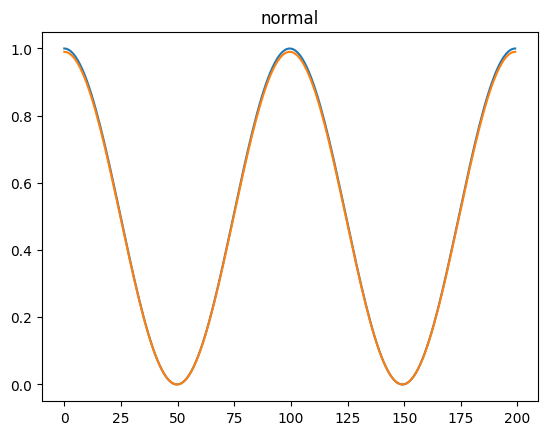

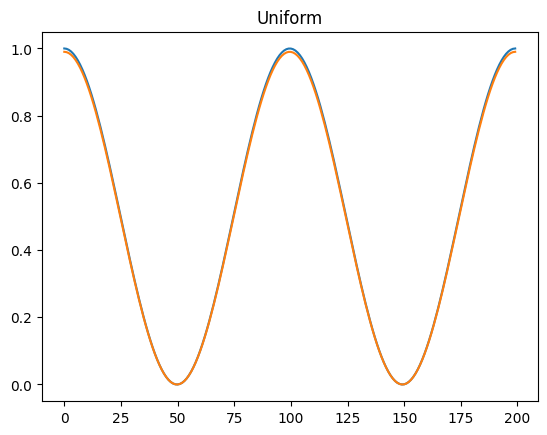

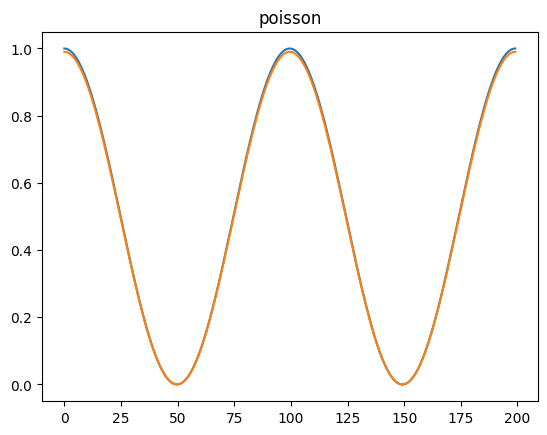

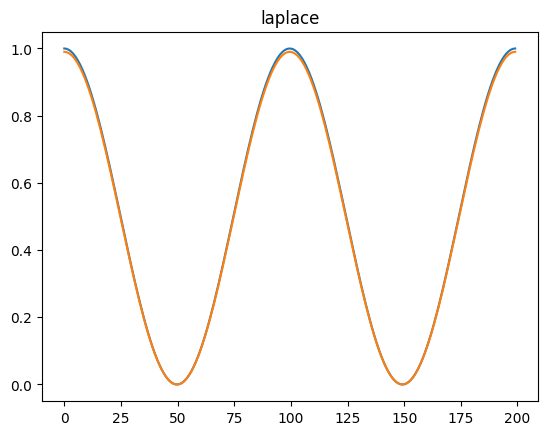

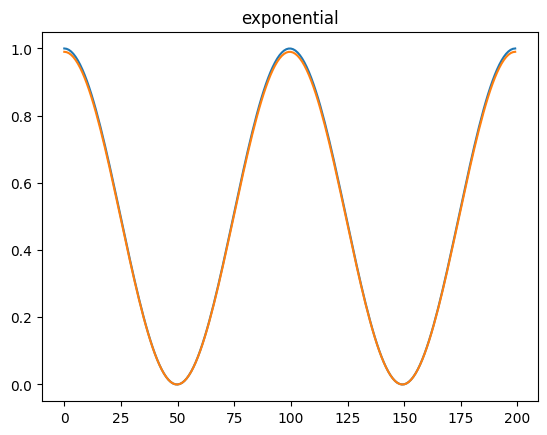

In [7]:
# %% Kernels and Functional Form of PDE
def P(S, s, P_coef):
    K_sS = rbf(S, s)
    return K_sS @ P_coef

f = np.cos(2 * np.pi * x)**2
# f = np.zeros_like(x)
SS = np.random.random((200, 600))

u_kx_normal = rbf_kernel_derivative(x, x, order=1).squeeze() @ solve(
    (u_rbf + 0.1*np.eye(Nx)), u_diff_smooth_normal
    )
u_kxx_normal = rbf_kernel_derivative(x, x, order=2).squeeze() @ solve(
    (u_rbf + 0.1*np.eye(Nx)), u_diff_smooth_normal
    )
s_normal = np.hstack([u_diff_smooth_normal, u_kx_normal, u_kxx_normal])
K_normal = rbf(s_normal,s_normal)
P_coef_normal = solve((K_normal + 0.01 * np.eye(Nx)), f)
f_new_normal = P(s_normal, s_normal, P_coef_normal)
plt.figure()
plt.title("normal")
plt.plot(f)
plt.plot(f_new_normal)

u_kx_uniform = rbf_kernel_derivative(x, x, order=1).squeeze() @ solve(
    (u_rbf + 0.1*np.eye(Nx)), u_diff_smooth_uniform
    )
u_kxx_uniform = rbf_kernel_derivative(x, x, order=2).squeeze() @ solve(
    (u_rbf + 0.1*np.eye(Nx)), u_diff_smooth_uniform
    )
s_uniform = np.hstack([u_diff_smooth_uniform, u_kx_uniform, u_kxx_uniform])
K_uniform = rbf(s_uniform,s_uniform)
P_coef_uniform = solve((K_uniform + 0.01 * np.eye(Nx)), f)
f_new_uniform = P(s_uniform, s_uniform, P_coef_uniform)
plt.figure()
plt.title("Uniform")
plt.plot(f)
plt.plot(f_new_uniform)

u_kx_poisson = rbf_kernel_derivative(x, x, order=1).squeeze() @ solve(
    (u_rbf + 0.1*np.eye(Nx)), u_diff_smooth_poisson
    )
u_kxx_poisson = rbf_kernel_derivative(x, x, order=2).squeeze() @ solve(
    (u_rbf + 0.1*np.eye(Nx)), u_diff_smooth_poisson
    )
s_poisson = np.hstack([u_diff_smooth_poisson, u_kx_poisson, u_kxx_poisson])
K_poisson = rbf(s_poisson,s_poisson)
P_coef_poisson = solve((K_poisson + 0.01 * np.eye(Nx)), f)
f_new_poisson = P(s_poisson, s_poisson, P_coef_poisson)
plt.figure()
plt.title("poisson")
plt.plot(f)
plt.plot(f_new_poisson)

u_kx_laplace = rbf_kernel_derivative(x, x, order=1).squeeze() @ solve(
    (u_rbf + 0.1*np.eye(Nx)), u_diff_smooth_laplace
    )
u_kxx_laplace = rbf_kernel_derivative(x, x, order=2).squeeze() @ solve(
    (u_rbf + 0.1*np.eye(Nx)), u_diff_smooth_laplace
    )
s_laplace = np.hstack([u_diff_smooth_laplace, u_kx_laplace, u_kxx_laplace])
K_laplace = rbf(s_laplace,s_laplace)
P_coef_laplace = solve((K_laplace + 0.01 * np.eye(Nx)), f)
f_new_laplace = P(s_laplace, s_laplace, P_coef_laplace)
plt.figure()
plt.title("laplace")
plt.plot(f)
plt.plot(f_new_laplace)

u_kx_exponential = rbf_kernel_derivative(x, x, order=1).squeeze() @ solve(
    (u_rbf + 0.1*np.eye(Nx)), u_diff_smooth_exponential
    )
u_kxx_exponential = rbf_kernel_derivative(x, x, order=2).squeeze() @ solve(
    (u_rbf + 0.1*np.eye(Nx)), u_diff_smooth_exponential
    )
s_exponential = np.hstack([u_diff_smooth_exponential, u_kx_exponential, u_kxx_exponential])
K_exponential = rbf(s_exponential,s_exponential)
P_coef_exponential = solve((K_exponential + 0.01 * np.eye(Nx)), f)
f_new_exponential = P(s_exponential, s_exponential, P_coef_exponential)
plt.figure()
plt.title("exponential")
plt.plot(f)
plt.plot(f_new_exponential)